In [ ]:
import warnings
warnings.filterwarnings("ignore")

%tensorflow_version 1.x

import tensorflow
print(tensorflow.__version__)

!pip install h5py==2.10.0
!pip install q keras==2.1.0

1.15.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git
!pwd

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
/content


In [ ]:
!ls
%cd Mask_RCNN
!pwd
!python3 setup.py install

gdrive	Mask_RCNN  sample_data
/content/Mask_RCNN
/content/Mask_RCNN
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info

In [ ]:
import os
import sys
import imagesize
import numpy as np
import math
from matplotlib import image

from mrcnn.config import Config
from mrcnn import model as modellib, utils

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

ROOT_DIR = os.path.abspath("./")
print(ROOT_DIR)

DRIVE_ROOT_DIR = "/content/gdrive/My Drive/mrcnn"

DEFAULT_LOGS_DIR = os.path.join(DRIVE_ROOT_DIR, "logs")
print(DEFAULT_LOGS_DIR)

COCO_WEIGHTS_PATH = os.path.join(DRIVE_ROOT_DIR, "mask_rcnn_coco.h5")
print(COCO_WEIGHTS_PATH)

LAST_WEIGHTS_PATH = os.path.join(DRIVE_ROOT_DIR, "mask_rcnn_floatingobjects_0100.h5")
print(LAST_WEIGHTS_PATH)

DATASET_DIR = os.path.join(DRIVE_ROOT_DIR, "dataset")
print(DATASET_DIR)

sys.path.append(ROOT_DIR)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/Mask_RCNN
/content/gdrive/My Drive/mrcnn/logs
/content/gdrive/My Drive/mrcnn/mask_rcnn_coco.h5
/content/gdrive/My Drive/mrcnn/mask_rcnn_floatingobjects_0100.h5
/content/gdrive/My Drive/mrcnn/dataset


In [ ]:
class FloatingObjectsConfig(Config):
    NAME = "FloatingObjects"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Number of classes including background
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = 10
    # Skip detection with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

class FloatingObjectsDataset(utils.Dataset):
    """
    Load a subset of Floating Objects dataset.
    dataset_dir: Root directory of the dataset.
    subset: Subset to load: train/validation/test
    """
    def load_objects(self, dataset_dir, subset):
        self.add_class("person", 1, "person")

        assert subset in ["train", "validation", "test"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        """
        YOLO: In YOLO labeling format, a .txt file with the
        same name is created for each image file in the same
        directory. Each .txt contains he annotations for the
        corresponding image file, that is object class, object
        coordinates, height and width.
        <object-class> <x> <y> <width> <height>
        """
        annotations = {}
        for annotation_filename in os.listdir(dataset_dir):
            if annotation_filename.endswith(".txt"):
                annotation_file_path = f"{dataset_dir}/{annotation_filename}"
                raw_filename = os.path.splitext(annotation_filename)[0]
                with open(annotation_file_path, 'rb') as f:
                    elements = []
                    raw_data = f.read().splitlines()
                    for line in raw_data:
                        line = line.decode("utf-8")
                        single_annotaton = line.split(' ')
                        # Remove bounding boxes for non-persons
                        if (single_annotaton[0] != '0'):
                            continue
                        elements.append(single_annotaton)
                        if (len(elements) == 0):
                            continue
                    annotations[raw_filename] = elements

        # Load images
        images = {}
        for image_filename in os.listdir(dataset_dir):
            if image_filename.endswith(".jpg"):
                raw_filename = os.path.splitext(image_filename)[0]
                if len(annotations[raw_filename]) == 0:
                    continue
                image_file_path = f"{dataset_dir}/{image_filename}"
                width, height = imagesize.get(image_file_path)
                images[raw_filename] = {}
                images[raw_filename]['path'] = image_file_path
                images[raw_filename]['width'] = width
                images[raw_filename]['height'] = height
                images[raw_filename]['annotations'] = annotations[raw_filename]


        for key in images:
            self.add_image(
                "person",
                image_id=key,
                path=images[key]['path'],
                width=images[key]['width'],
                height=images[key]['height'],
                annotations=images[key]['annotations'])


    def yolo_to_box(self, yolo_annotation: list, img_width, img_height):
        """
        Trasform bounding boxes in YOLO 
        format to standard bounding boxes
        """
        x = float(yolo_annotation[1])
        y = float(yolo_annotation[2])
        width = float(yolo_annotation[3])
        height = float(yolo_annotation[4])

        x_min, y_min = int((x-width/2)* img_width), int((y-height/2)*img_height)
        x_max, y_max = int((x+width/2) * img_width), int((y+height/2)*img_height)

        return [x_min, y_min, x_max, y_max]

    def load_mask(self, image_id):
        """
        Generate instance mask for an image
        """
        info = self.image_info[image_id]

        # Transform bounding boxes in YOLO
        # format to standard bounding boxes
        boxes = []
        for element in info['annotations']:
            box = self.yolo_to_box(element, info['width'], info['height'])
            boxes.append(box)

        # Create one array for all masks, each on different channel
        masks = np.zeros([info['height'], info['width'], len(boxes)], dtype='uint8')

        # Create masks
        for index in range(len(boxes)):
            box = boxes[index]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, index] = 1

        return masks.astype(np.bool), np.ones([masks.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """
        Return the path of the image.
        """
        info = self.image_info[image_id]
        return info['path']

In [ ]:
dataset_train = FloatingObjectsDataset()
dataset_validation = FloatingObjectsDataset()

def train(model, dataset_train, dataset_validation):
    """
    Train the model
    """
    # Prepare training dataset
    print("Preparing datasets...")
    
    dataset_train.load_objects(DATASET_DIR, "train")
    dataset_train.prepare()
    print("Training dataset prepared.")

    dataset_validation.load_objects(DATASET_DIR, "validation")
    dataset_validation.prepare()
    print("Validation dataset prepared.")

    print("Training network heads...")
    model.train(
        dataset_train,
        dataset_validation,
        learning_rate=config.LEARNING_RATE,
        epochs=100,
        layers='heads')
    

# Configuration
config = FloatingObjectsConfig()
config.display()
model = modellib.MaskRCNN(
            mode="training",
            config=config,
            model_dir=DEFAULT_LOGS_DIR
        )


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# weights_path = COCO_WEIGHTS_PATH
# print(weights_path)
# model.load_weights(
#             weights_path,
#             by_name=True,
#             exclude=[
#             "mrcnn_class_logits", "mrcnn_bbox_fc",
#             "mrcnn_bbox", "mrcnn_mask"]
#         )

/content/gdrive/My Drive/mrcnn/mask_rcnn_coco.h5








Wagi własne

In [ ]:
# Ostatnie wagi
# weights_path = model.find_last()
# model.load_weights(weights_path, by_name=True)

# Wybrane wagi
weights_path = LAST_WEIGHTS_PATH
model.load_weights(weights_path, by_name=True)

print("Loading weights ", weights_path)

Loading weights  /content/gdrive/My Drive/mrcnn/mask_rcnn_floatingobjects_0100.h5


In [ ]:
train(model, dataset_train=dataset_train, dataset_validation=dataset_validation)

Preparing datasets...
Training dataset prepared.
Validation dataset prepared.
Training network heads...

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/gdrive/My Drive/mrcnn/logs/floatingobjects20220611T1453/mask_rcnn_floatingobjects_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mr

In [ ]:
# # https://github.com/matterport/Mask_RCNN/issues/2513

# from mrcnn import utils
# from sklearn import metrics

# def compute_ar(pred_boxes, gt_boxes, list_iou_thresholds):
# # pred_boxes: Are the coordinates of the expected bounding box;
# # gt_boxes: Are the coordinates of the actual bounding box;
# # list_iou_thresholds: List of thresholds that will be used.
#   AR = []
#   for iou_threshold in list_iou_thresholds:

#       try:
#           recall, _ = utils.compute_recall(pred_boxes, gt_boxes, iou=iou_threshold)

#           AR.append(recall)

#       except:
#         AR.append(0.0)
#         pass

#   AUC = 2 * (metrics.auc(list_iou_thresholds, AR))
#   return AUC

# New Section

In [ ]:
# from mrcnn import utils
# from statistics import mean
# # from modellib import load_image_gt, mold_image, expand_dims, compute_ap, compute_ar
# from mrcnn import model as modellib
# def evaluate_model(dataset, model, cfg, list_iou_thresholds=None):
#   """
#   dataset - an object of a class that inherits from the Dataset class in utils.py
#   model - an object resulting from the MaskRCNN class available in the module model.py
#   cfg - an object of a class that inherits the super class config.py
#   """
#   if list_iou_thresholds is None: list_iou_tresholds = np.arange(0.5, 1.01, 0.1)

#   APs = [] # average precision
#   ARs = [] # average recall

#   for image_id in dataset.image_ids:
#     image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id, use_mini_mask=False)

#     r = model.detect([image])
#     r = r[0]

#     AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                                                    r["rois"], r["class_ids"], r["scores"], 
#                                                    r['masks'], iou_threshold=0.5)
    
#     AR = compute_ar(r['rois'], gt_bbox, list_iou_thresholds)
#     print(AP)
    
#     APs.append(AP)
#     ARs.append(AR)

#   mAP = mean(APs)
#   mAR = mean(ARs)
#   return mAP, mAR

In [ ]:
# mAP, mAR = evaluate_model(dataset_validation, model, SimpleConfig(), np.arange(0.5, 1.01, 0.1))

StatisticsError: ignored

In [ ]:
# print(mAP)
# print(mAR)

0.0
0.0


**Model evaluation**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# class SimpleConfig(Config):
#   NAME = "inference"
#   GPU_COUNT = 1
#   IMAGES_PER_GPU = 1
#   NUM_CLASSES = 1 + 1

In [ ]:
# # https://github.com/matterport/Mask_RCNN/issues/2513

# from mrcnn import utils
# from sklearn import metrics

# def compute_ar(pred_boxes, gt_boxes, list_iou_thresholds):
# # pred_boxes: Are the coordinates of the expected bounding box;
# # gt_boxes: Are the coordinates of the actual bounding box;
# # list_iou_thresholds: List of thresholds that will be used.
#   AR = []
#   for iou_threshold in list_iou_thresholds:

#       try:
#           recall, _ = utils.compute_recall(pred_boxes, gt_boxes, iou=iou_threshold)

#           AR.append(recall)

#       except:
#         AR.append(0.0)
#         pass

#   AUC = 2 * (metrics.auc(list_iou_thresholds, AR))
#   return AUC



Image detection

Loading test set...
Test set loaded.
image ID: person.a_317 (169) /content/gdrive/My Drive/mrcnn/dataset/test/a_317.jpg


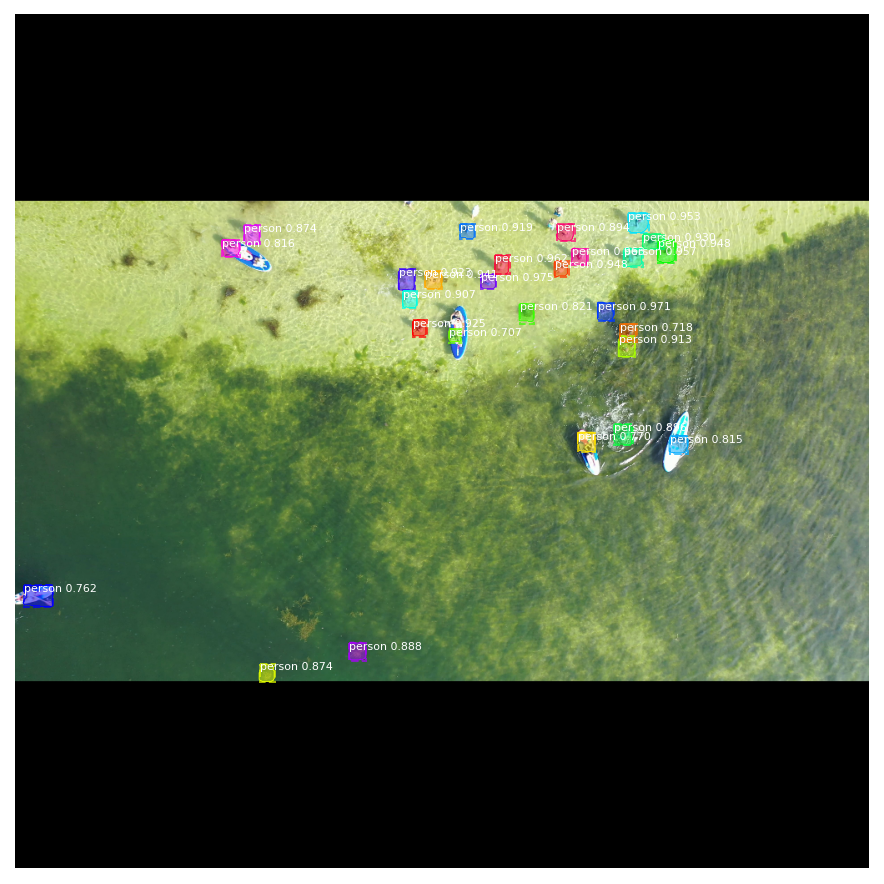

In [ ]:
# # https://blog.paperspace.com/object-detection-directed-mask-r-cnn-keras/
# import random
# import mrcnn.config
# import mrcnn.model
# import mrcnn.visualize
# import cv2
# import os

# PHOTO_PATH = DRIVE_ROOT_DIR + "/dataset/test/a_389.jpg"
# # PHOTO_PATH = DRIVE_ROOT_DIR + "/dataset/Fig07.jpg"
# CLASS_NAMES = ["BG", "person"]

# print("Loading test set...")
# dataset_test = FloatingObjectsDataset()
# dataset_test.load_objects(DATASET_DIR, "test")
# dataset_test.prepare()
# print("Test set loaded.")

# model = mrcnn.model.MaskRCNN(mode="inference",
#                              config=SimpleConfig(),
#                              model_dir=os.getcwd())

# # model.load_weights(filepath=COCO_WEIGHTS_PATH,
# #                    by_name=True,exclude=[ "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

# model.load_weights(weights_path, by_name=True)

# # https://github.com/matterport/Mask_RCNN/issues/363

# # image=cv2.imread(PHOTO_PATH)
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image_id = random.choice(dataset_test.image_ids)
# image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, config, image_id, use_mini_mask=False)
# info = dataset_test.image_info[image_id]
# print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#                                        dataset_test.image_reference(image_id)))



# r = model.detect([image])

# r = r[0]

# mrcnn.visualize.display_instances(image=image, 
#                                   boxes=r['rois'], 
#                                   masks=r['masks'], 
#                                   class_ids=r['class_ids'], 
#                                   class_names=CLASS_NAMES, 
#                                   scores=r['scores'])